# Dogs V.S. Cats
## Environment Configuration

In [1]:
%pip install kaggle


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip -q -n dogs-vs-cats.zip


In [4]:
!unzip -q -n train.zip

## Build Custom Dataset

In [5]:
import os, shutil, pathlib

In [6]:
original_dir = pathlib.Path('train')
new_base_dir = pathlib.Path('cats_vs_dogs_small')

def make_subset(subset_name, start_index, end_index):
    for category in ('cat', 'dog'):
        dir = new_base_dir / subset_name / category
        try:
            os.makedirs(dir)
        except FileExistsError:
            return
        fnames = [f"{category}.{i}.jpg"
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset('train', 0, 1000)
make_subset('validation', 1000, 1500)
make_subset('test', 1500, 2500)

## Building the model

In [7]:
from tensorflow import keras
from keras import layers

In [8]:
inputs= keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [10]:
from tensorflow.keras.utils import image_dataset_from_directory

In [11]:
train_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'train',
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'validation',
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'test',
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [12]:
for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='convnet_from_scratch.keras',
        save_best_only=True,
        monitor='val_loss')
]

In [14]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 352ms/step - accuracy: 0.5060 - loss: 0.7029 - val_accuracy: 0.6180 - val_loss: 0.6918
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.5591 - loss: 0.6935 - val_accuracy: 0.5100 - val_loss: 0.6887
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 344ms/step - accuracy: 0.5750 - loss: 0.6806 - val_accuracy: 0.6350 - val_loss: 0.6533
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 345ms/step - accuracy: 0.6316 - loss: 0.6497 - val_accuracy: 0.6460 - val_loss: 0.6241
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - accuracy: 0.6607 - loss: 0.6191 - val_accuracy: 0.6570 - val_loss: 0.6097
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.6715 - loss: 0.5922 - val_accuracy: 0.6270 - val_loss: 0.6525
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - accuracy: 0.7197 - loss: 0.5530 - val_accuracy: 0.7080 - val_loss: 0.5608
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 359ms/step - accuracy: 0.7447 - loss: 0.5063 - val_accu

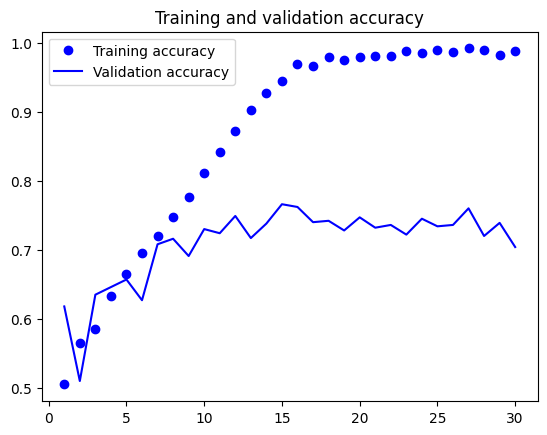

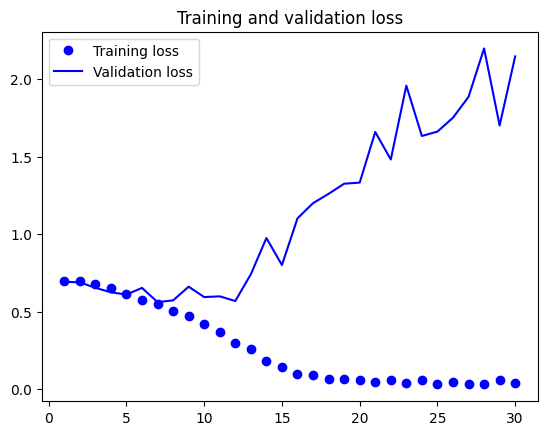

In [15]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [16]:
test_model = keras.models.load_model('convnet_from_scratch.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.2f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.6959 - loss: 0.5667
Test accuracy: 0.70


### Using Data Augmenmtation

In [17]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

2024-09-17 22:51:52.872214: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


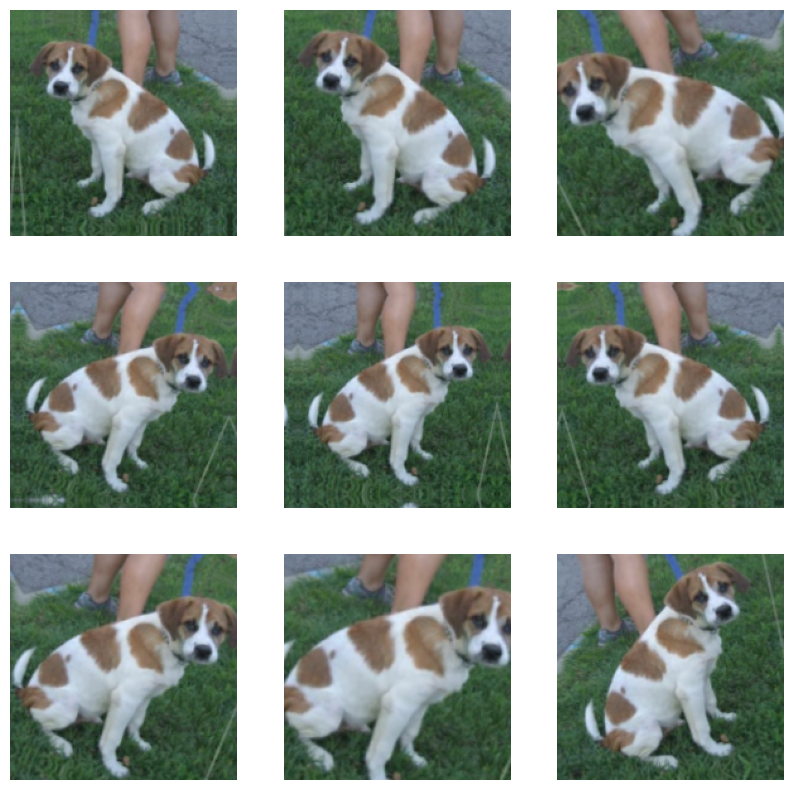

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) 
        plt.axis("off")

In [ ]:
inputs= keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='convnet_from_scratch_with_augmentation.keras',
        save_best_only=True,
        monitor='val_loss')
]

In [23]:
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 378ms/step - accuracy: 0.9969 - loss: 0.0144 - val_accuracy: 0.7210 - val_loss: 1.7022
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.9931 - loss: 0.0236 - val_accuracy: 0.7380 - val_loss: 2.0825
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - accuracy: 0.9899 - loss: 0.0304 - val_accuracy: 0.7120 - val_loss: 1.9525
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 382ms/step - accuracy: 0.9953 - loss: 0.0176 - val_accuracy: 0.7390 - val_loss: 2.1048
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.9910 - loss: 0.0265 - val_accuracy: 0.7340 - val_loss: 1.9816
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.9971 - loss: 0.0116 - val_accuracy: 0.7420 - val_loss: 2.6489
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 352ms/step - accuracy: 0.9878 - loss: 0.0483 - val_accuracy: 0.7220 - val_loss: 2.4589
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 361ms/step - accuracy: 0.9967 - loss: 0.0113 - 

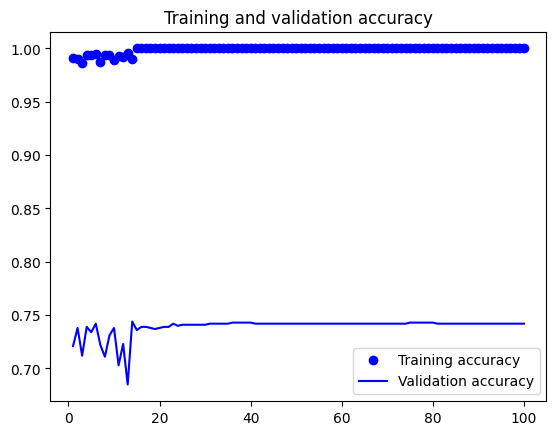

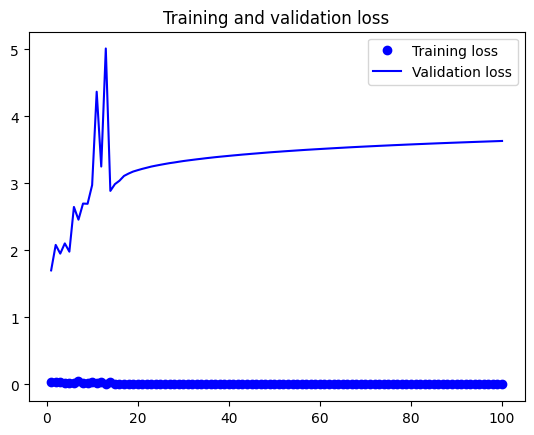

In [24]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
test_model = keras.models.load_model('convnet_from_scratch.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.2f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6983 - loss: 0.5629
Test accuracy: 0.70
